# Single Neuron Neural Network on Synthetic time series data

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


Defining a plotting function of plotting series

In [17]:
def plot_series(time, series, format="-", start = 0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("time")
  plt.ylabel("series")
  plt.grid(True)


### Trend, Seasonality, Noise

In [6]:
def trend(time, slope= 0):
  return slope*time

def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time*2*np.pi),
                  1/np.exp(3*season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time+phase) % period)/period
  return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

time = np.arange(4*365+1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
  


Create the Series

In [7]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# update the series with Noise

series+=noise(time, noise_level, seed=42)

Splitting the data --> Training set and Validation set

In [8]:
split_time = 1000
train_time = time[:split_time]
train_series = series[:split_time]

valid_time = time[split_time:]
valid_series = series[split_time:]

In [9]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

## Preparing Dataset

In [11]:
def windowed_dataset(series, window_size,batch_size,shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Neural Network

In [12]:
dataset = windowed_dataset(train_series, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

print("layer weights: {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>
layer weights: [array([[ 0.00476314],
       [-0.01597142],
       [-0.04280324],
       [-0.01485088],
       [ 0.07119334],
       [ 0.08362688],
       [-0.108477  ],
       [ 0.05395908],
       [-0.0909364 ],
       [ 0.10506715],
       [ 0.00633469],
       [-0.04541546],
       [-0.11450014],
       [ 0.1350677 ],
       [ 0.02502291],
       [ 0.04604248],
       [ 0.03706652],
       [ 0.16199377],
       [ 0.20639662],
       [ 0.5026439 ]], dtype=float32), array([0.01644155], dtype=float32)]


## Forecast

In [15]:
forecast = []

for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results=np.array(forecast)[:, 0, 0]



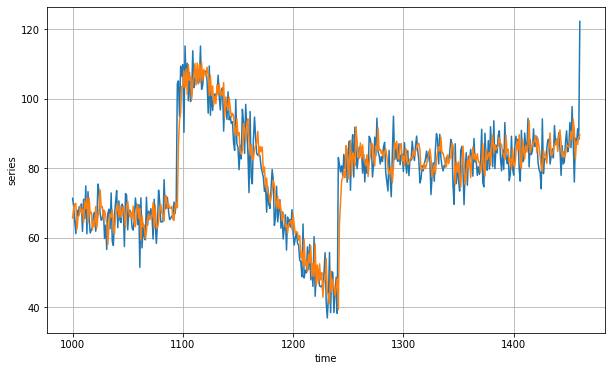

In [18]:
plt.figure(figsize=(10,6))
plot_series(valid_time, valid_series)
plot_series(valid_time, results)

In [20]:
tf.keras.metrics.mean_absolute_error(valid_series, results).numpy()

5.1947656